In [1]:
%load_ext cython
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


from scipy import stats
from scipy.optimize import curve_fit

MP = 0.93827208816
E0 = 4.81726
ME = 0.00051099895


In [2]:
%%cython --annotate
import numpy as np
cimport numpy as np
from libc.math cimport sin, cos, sqrt
cimport cython

cdef float MP = 0.93827208816
cdef float E0 = 4.81726
cdef float ME = 0.00051099895

@np.vectorize
def calc_W(e_p, e_theta, e_phi):
    px = e_p*sin(e_theta)*cos(e_phi)
    py = e_p*sin(e_theta)*sin(e_phi)
    pz = e_p*cos(e_theta)
    
    e_beam = np.array([0, 0, np.sqrt(E0**2-ME**2), E0])
    e_prime = np.array([px, py, pz, np.linalg.norm([px, py, pz, ME])])
    p_targ = np.array([0, 0, 0.0, MP])
    temp = e_beam - e_prime + p_targ
    temp2 = temp[0]*temp[0]+temp[1]*temp[1]+temp[2]*temp[2]-temp[3]*temp[3]
    temp3 = np.sqrt(-temp2)
    return temp3

@np.vectorize
def q2_calc(e_p, e_theta, e_phi):
    px = e_p*sin(e_theta)*cos(e_phi)
    py = e_p*sin(e_theta)*sin(e_phi)
    pz = e_p*cos(e_theta)
    
    e_beam = np.array([0, 0, sqrt(E0**2-ME**2), E0])
    e_prime = np.array([px, py, pz, np.linalg.norm([px, py, pz, ME])])
    
    temp = e_beam - e_prime
    temp2 = temp[0]*temp[0]+temp[1]*temp[1]+temp[2]*temp[2]-temp[3]*temp[3]

    return temp2

@np.vectorize
def correct_W(e_p, theta, A, B, C, D, E, F):
    return A*calc_W(B*e_p + E, C*theta + F, np.zeros_like(e_p))+D

@np.vectorize
def correct_Q2(e_p, theta, A, B, C, D, E, F):
    return A*q2_calc(B*e_p + E, C*theta + F, np.zeros_like(e_p))+D

In [3]:
@np.vectorize
def center_phi(phi, sec):
    sector = {
        1: 90,
        2: 30,
        3: -30,
        4: -90,
        5: -150,
        6: 150
    }
    
    return phi-sector[sec]

@np.vectorize
def Theta_e_calc(theta_p):
    return 2 * np.arctan(MP/((E0+MP)*np.tan(theta_p)))

def gauss(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))



def FitFunc(phi_e, theta_e, 
            alpha_A, beta_A, gamma_A, 
            alpha_B, beta_B, gamma_B, 
            alpha_C, beta_C, gamma_C,
            alpha_D, beta_D, gamma_D,
            alpha_E, beta_E, gamma_E):
    """
    Equations 5.20 - 5.22 in KPark thesis (p. 71)
    """
    A = (alpha_A * theta_e**2 + beta_A * theta_e + gamma_A) * phi_e**4
    B = (alpha_B * theta_e**2 + beta_B * theta_e + gamma_B) * phi_e**3
    C = (alpha_C * theta_e**2 + beta_C * theta_e + gamma_C) * phi_e**2
    D = (alpha_D * theta_e**2 + beta_D * theta_e + gamma_D) * phi_e
    E = (alpha_E * theta_e**2 + beta_E * theta_e + gamma_E)
    
    return A + B + C + D + E


def Dtheta(phi_e, theta_e, A, B, C, D, Bt):
    """
    Mom Corrections for e6 (CLAS-NOTE 2003-005) 
    """
    first = (A+B*phi_e)*(np.cos(theta_e)/np.cos(phi_e))
    second = (C+D*phi_e)*np.sin(theta_e)
    return first + second

def Dpp(phi_e, theta_e, p, E, F, G, H):
    first = (E+F*phi_e)*(np.cos(theta_e)/np.cos(phi_e))
    second = (G+H*phi_e)*np.sin(theta_e)
    
    return (first + second)*(p/Bt)
 

def FitWHist(X, A, B, C, D, E, F):
    e_p, theta = X
    w_new = correct_W(e_p, theta, A, B, C, D, E, F)
    w_new = w_new[np.isfinite(w_new)]
    plt.hist(w_new, bins=250, range=(0.85,1.05), density=True)
    w_new = w_new[w_new > 0.9]
    w_new = w_new[w_new < 1.0]
    plt.hist(w_new, bins=250, range=(0.85,1.05), density=True, alpha=0.2)
    mu, std = stats.norm.fit(w_new)
    xs = np.linspace(0.85,1.05, 2500)
    p = stats.norm.pdf(xs, mu, std)
    plt.plot(xs, p, 'k', linewidth=2)
    plt.show()
    print(np.abs(mu-MP),np.abs(std), np.abs(mu-MP)**2)
    print([A, B, C, D, E, F])
    return np.abs(mu-MP)**2
    

In [4]:
df = pd.read_csv("~/Desktop/show/mom_corr_elastic.dat")
df = df[(df.W_uncorr > 0.85) & (df.W_uncorr < 1.2)]
df['e_theta'] = np.deg2rad(df.e_theta)
df['e_phi_center'] = np.deg2rad(center_phi(df.e_phi, df.sector))
df['e_phi'] = np.deg2rad(df.e_phi)
df['p_theta'] = np.deg2rad(df.p_theta)
df['p_phi'] = np.deg2rad(df.p_phi)
df['e_theta_calc'] = Theta_e_calc(df.p_theta)
df['delta_theta'] = df['e_theta_calc']-df['e_theta']
df['w_corr'] = calc_W(df.e_p, df.e_theta, np.zeros_like(df.e_phi))
df['q2_corr'] = q2_calc(df.e_p, df.e_theta, np.zeros_like(df.e_phi))
df['p_p_calc'] = Theta_e_calc(df.e_theta_calc)
df = df[np.abs(df.delta_theta) < 0.005]

print(len(df))

248916


In [5]:
df.head()

,e_p,e_theta,e_phi,p_p,p_theta,p_phi,W_uncorr,Q2_uncorr,sector,e_phi_center,e_theta_calc,delta_theta,w_corr,q2_corr,p_p_calc
0,3.867114,0.302877,-0.630023,1.606884,0.822251,2.523154,0.983592,1.695892,3,-0.106424,0.300571,-0.002306,0.983592,1.695893,0.968364
2,3.823474,0.320880,1.468849,1.707246,0.789636,-1.651257,0.930052,1.880240,1,-0.101948,0.320518,-0.000362,0.930053,1.880239,0.912973
4,3.808950,0.320004,2.788525,1.675734,0.789702,-0.359243,0.953690,1.862967,6,0.170531,0.320476,0.000472,0.953689,1.862969,0.913083
5,4.044248,0.268281,-1.527046,1.388920,0.881333,1.606775,0.968046,1.393833,4,0.043751,0.267199,-0.001082,0.968044,1.393835,1.074239
6,3.907971,0.292540,1.706743,1.572335,0.835882,-1.425245,0.993494,1.599645,1,0.135946,0.292574,0.000033,0.993494,1.599645,0.992134


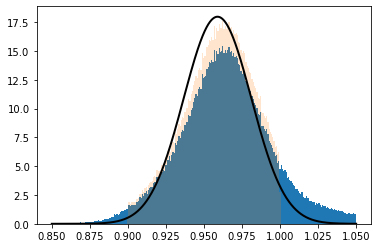

0.0206224607310731 0.022202669939475332 0.00042528588660465207
[1.0, 1.0, 1.0, 0.0, 0.0, 0.0]


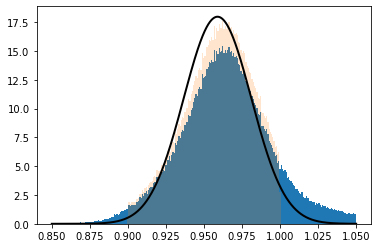

0.0206224607310731 0.022202669939475332 0.00042528588660465207
[1.0, 1.0, 1.0, 0.0, 0.0, 0.0]


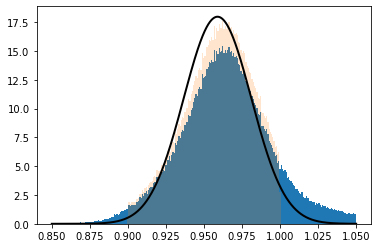

0.0206224607310731 0.022202669939475332 0.00042528588660465207
[1.0, 1.0, 1.0, 0.0, 0.0, 0.0]


KeyboardInterrupt: 

In [6]:
p0 = [1.0, 1.0, 1.0, 0.0, 0.0, 0.0]

popt, pcov = curve_fit(FitWHist, (df.e_p, df.e_theta), np.zeros_like(df.e_p), p0=p0, maxfev=100)

print(*popt)

In [ ]:
df['w_corr'] = correct_W(df.e_p, df.e_theta, *popt)
df['q2_corr'] = correct_Q2(df.e_p, df.e_theta, *popt)

In [ ]:
plt.hist(df.w_corr, bins=500)
plt.hist(df.W_uncorr, bins=500, alpha=0.2)
plt.show()

In [ ]:
plt.hist2d(df.w_corr,df.q2_corr , bins=500)
plt.show()

In [ ]:
plt.hist2d(df.W_uncorr, df.Q2_uncorr, bins=500)
plt.show()